In [4]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg; Pkg.activate(@__DIR__)
Pkg.instantiate()

using DataFrames
using Plots
using CategoricalArrays
using Random
using MLJBase: machine, transform
using TableTransforms
using Imbalance

  Activating project at `~/Documents/GitHub/Imbalance.jl/examples`


   Resolving package versions...


    Updating `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  [f1d291b0] + MLUtils v0.4.3
    Updating `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


  [a9b6321e] + Atomix v0.1.0
  [fa961155] + CEnum v0.4.2
  [6add18c4] + ContextVariablesX v0.1.3
  [cc61a311] + FLoops v0.2.1
  [b9860ae5] + FLoopsBase v0.1.1
  [46192b85] + GPUArraysCore v0.1.5
  [b14d175d] + JuliaVariables v0.2.4
  [63c18a36] + KernelAbstractions v0.9.8
  [929cbde3] + LLVM v6.2.1
  [d8e11817] + MLStyle v0.4.17
  [f1d291b0] + MLUtils v0.4.3
⌅ [872c559c] + NNlib v0.8.21
  [71a1bf82] + NameResolution v0.1.5
  [8162dcfd] + PrettyPrint v0.2.0
  [699a6c99] + SimpleTraits v0.9.4
  [013be700] + UnsafeAtomics v0.2.1
  [d80eeb9a] + UnsafeAtomicsLLVM v0.1.3
  [dad2f222] + LLVMExtra_jll v0.0.25+0
  [4af54fe1] + LazyArtifacts
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`


### 1. Generate Random Data

In [7]:
rng = Random.default_rng()

type="ColTable"
num_rows = 50
num_features = 2
probs = [0.5, 0.2, 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(num_rows, num_features; probs, type, insert_y=y_ind, rng=42)
X, y = generate_imbalanced_data(num_rows, num_features; probs, type, rng=42)

((Column1 = [0.10083458248601018, 0.32106572972106817, 0.9695150609084499, 0.012898301755861596, 0.7555027304121053, 0.3467415729179013, 0.35969402837473463, 0.2601876747805505, 0.9153753178220317, 0.907410564584128  …  0.12897177983538477, 0.6863866635957644, 0.9452279486233184, 0.6135953031731222, 0.7393683025755258, 0.49776424409145725, 0.6193417397007426, 0.363826187287986, 0.7584295856669816, 0.2184451048446261], Column2 = [0.3895982138874483, 0.08174960438833156, 0.6636644264313925, 0.7304405732047541, 0.027800141050299598, 0.20874452928568255, 0.5612819555303167, 0.5693791212655085, 0.2787942224536374, 0.5598733934174821  …  0.4479438784027816, 0.23004681363952995, 0.021532597906190776, 0.8482825697641306, 0.10773487816863903, 0.32189982199036116, 0.35339667381702744, 0.06606899106550812, 0.19451065500145392, 0.9638103356367584]), CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 1, 0, 0, 2, 2, 0  …  2, 0, 2, 0, 0, 2, 1, 0, 2, 0])

### 2. Apply ENN Undersampler

#### Using Imbalance Only

In [8]:
X_under, y_under = enn_undersample(X, y; keep_condition="mode", min_ratios = 0.01, rng = 42)
checkbalance(y_under)

1: ▇▇ 1 (5.0%) 
2: ▇▇▇▇▇▇▇▇▇▇▇▇ 5 (25.0%) 
0: ▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇ 20 (100.0%) 


#### Using MLJ

In [9]:
naive_model = Imbalance.MLJ.ENNUndersampler(k=4, min_ratios=Dict(0=>1.0, 1=> 1.0, 2=>0.9), rng=42)
mach = machine(naive_model)
X_under, y_under = transform(mach, X, y)

((Column1 = [0.10083458248601018, 0.32106572972106817, 0.9695150609084499, 0.3467415729179013, 0.907410564584128, 0.7839550064174631, 0.9848878347210348, 0.6769816833132287, 0.816258796332574, 0.7141515981270439  …  0.2601876747805505, 0.9153753178220317, 0.5466054557064257, 0.6301284079514171, 0.8892332330408234, 0.8963696919829013, 0.17270554743724298, 0.5441482812064661, 0.9452279486233184, 0.49776424409145725], Column2 = [0.3895982138874483, 0.08174960438833156, 0.6636644264313925, 0.20874452928568255, 0.5598733934174821, 0.020998560449319137, 0.6368862414922253, 0.6647153939263821, 0.9143124936256747, 0.7840808032600481  …  0.5693791212655085, 0.2787942224536374, 0.3012982513702701, 0.3933312404451116, 0.19272132336206282, 0.7151946665095478, 0.8480305241948735, 0.019763528714939915, 0.021532597906190776, 0.32189982199036116]), Any[CategoricalValue{Int64, UInt32} 0, CategoricalValue{Int64, UInt32} 0, CategoricalValue{Int64, UInt32} 0, CategoricalValue{Int64, UInt32} 0, Categorical

#### Using TableTransforms

In [10]:
using Imbalance: TableTransforms.ENNUndersampler
naive_model_t = ENNUndersampler(y_ind, min_ratios=Dict(0=>1.0, 1=> 0.9, 2=>1.0), rng=42)
Xyover = Xy |> naive_model_t

(Column1 = [0.10083458248601018, 0.32106572972106817, 0.9695150609084499, 0.012898301755861596, 0.3467415729179013, 0.907410564584128, 0.9848878347210348, 0.6769816833132287, 0.816258796332574, 0.7141515981270439  …  0.5466054557064257, 0.046782892974334134, 0.6301284079514171, 0.8892332330408234, 0.1852783785870693, 0.8963696919829013, 0.5441482812064661, 0.12897177983538477, 0.9452279486233184, 0.49776424409145725],
 Column2 = [0.3895982138874483, 0.08174960438833156, 0.6636644264313925, 0.7304405732047541, 0.20874452928568255, 0.5598733934174821, 0.6368862414922253, 0.6647153939263821, 0.9143124936256747, 0.7840808032600481  …  0.3012982513702701, 0.687746776535413, 0.3933312404451116, 0.19272132336206282, 0.22170985093210338, 0.7151946665095478, 0.019763528714939915, 0.4479438784027816, 0.021532597906190776, 0.32189982199036116],
 Column3 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],)

### 3. Plot the Results

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/simple_examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/simple_examples/Manifest.toml`


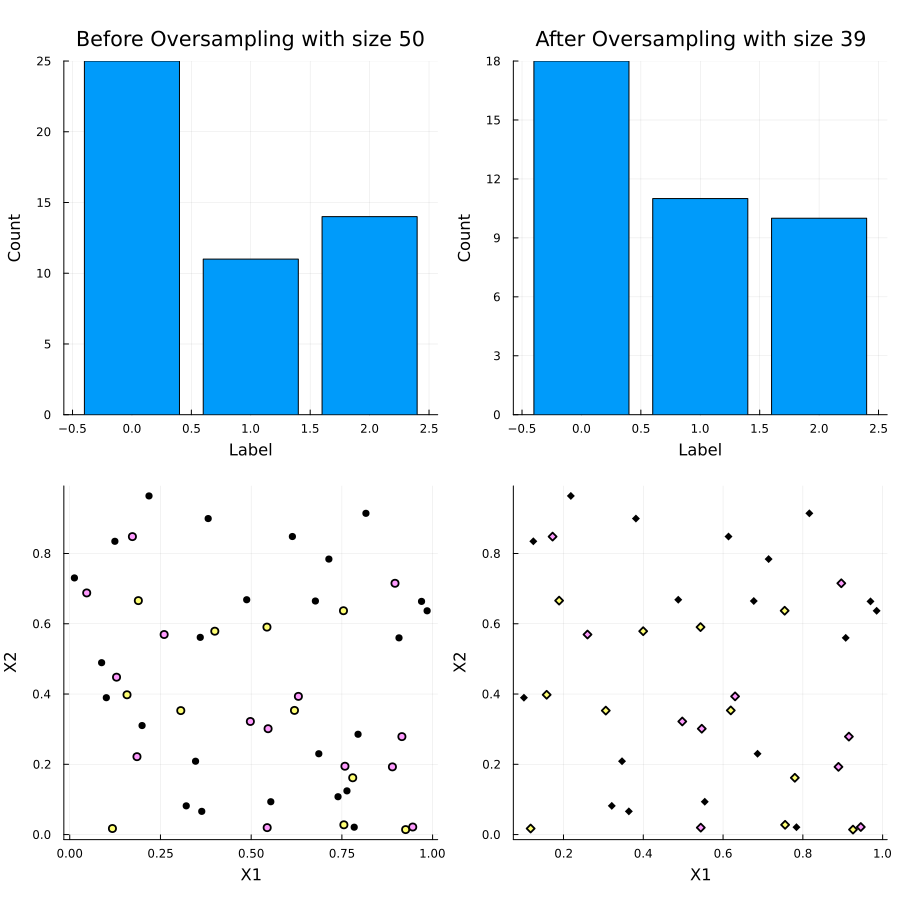

In [11]:
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, y_under, X, X_under)